# Install detectron2

In [0]:
# install dependencies
!pip install -U torch torchvision cython
!pip install -U 'git+https://github.com/facebookresearch/fvcore.git' 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
torch.__version__

Restart runtime after executing this cell.

In [0]:
!git clone https://github.com/facebookresearch/detectron2
!pip install -e detectron2

# Prepare training and testing data from google drive

In [1]:
# Mount google drive.
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
%cd /gdrive/'My Drive'/'DLCV Homework'/HW04/final/
! cp -r ../data ./
! cp -r ../result ./
! cp ../*.py ./
! cp ../Mask_

In [1]:
# Copy annotation file.
! mkdir -p data
! cp /gdrive/'My Drive'/'DLCV Homework'/HW04/data/pascal_train.json ./data
! cp /gdrive/'My Drive'/'DLCV Homework'/HW04/data/test.json ./data
# Copy images.
! cp /gdrive/'My Drive'/'DLCV Homework'/HW04/data/train_images.zip ./data
! unzip -q -d ./data ./data/train_images.zip
! cp /gdrive/'My Drive'/'DLCV Homework'/HW04/data/test_images.zip ./data
! unzip -q -d ./data ./data/test_images.zip
# Copy config files.
! cp /gdrive/'My Drive'/'DLCV Homework'/HW04/configs/* detectron2/configs/COCO-InstanceSegmentation/
# Copy utils.py
! cp /gdrive/'My Drive'/'DLCV Homework'/HW04/utils.py ./

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


# Import packages

In [0]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import random
from google.colab.patches import cv2_imshow
import os

# import some common detectron2 utilities
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

# Register the dataset

In [0]:
from detectron2.data.datasets import register_coco_instances
from detectron2.data import DatasetCatalog, MetadataCatalog

# Register the dataset.
register_coco_instances(
    "train_dataset", {}, "data/pascal_train.json", "data/train_images")
register_coco_instances(
    "test_dataset", {}, "data/test.json", "data/test_images")

To verify the data loading is correct, let's visualize the annotations of randomly selected samples in the training set:



In [0]:
# Get the registered training dataset.
train_data = DatasetCatalog.get("train_dataset")
# Get the built training meta data.
train_metadata = MetadataCatalog.get("train_dataset")

for d in random.sample(train_data, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

## Train!
Load the config file.


In [0]:
from detectron2.config import get_cfg

cfg = get_cfg()
# Path to the config file.
cfg.merge_from_file(
    './detectron2/configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_decay_0.01_momentum_0.9.yaml')
cfg.OUTPUT_DIR = '/gdrive/My Drive/DLCV Homework/HW04/train_logs/mask_rcnn/decay_0.01_momentum_0.9/'

Start training.

In [0]:
from detectron2.engine import DefaultTrainer

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

## Inference & evaluation using the trained model
Now, let's run inference with the trained model on the balloon validation dataset. First, let's create a predictor using the model we just trained:



In [0]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.DATASETS.TEST = ("test_dataset",)
# Set the testing threshold for this model.
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.8
predictor = DefaultPredictor(cfg)

Visualize the prediction.

In [0]:
! ls -l data/test_images/ | head -10

total 11988
-rw-r--r-- 1 root root  80285 Jan  9  2007 2007_000629.jpg
-rw-r--r-- 1 root root  90203 Jan 10  2007 2007_001175.jpg
-rw-r--r-- 1 root root  94660 Jan 10  2007 2007_001239.jpg
-rw-r--r-- 1 root root  93181 Jan 10  2007 2007_001733.jpg
-rw-r--r-- 1 root root  76524 Jan 10  2007 2007_002719.jpg
-rw-r--r-- 1 root root 138820 Jan 10  2007 2007_002823.jpg
-rw-r--r-- 1 root root  91446 Jan  9  2007 2007_002824.jpg
-rw-r--r-- 1 root root  96311 Jan 10  2007 2007_002903.jpg
-rw-r--r-- 1 root root 108628 Jan  9  2007 2007_003106.jpg


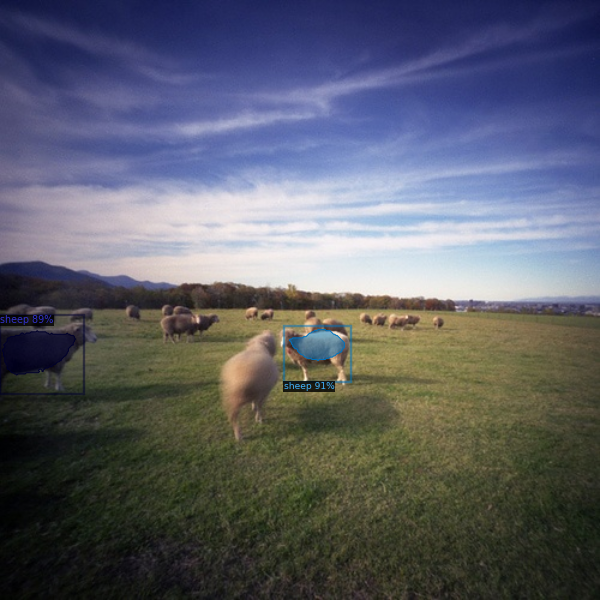

In [0]:
im = cv2.imread('./data/test_images/2007_001733.jpg')
outputs = predictor(im)
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TEST[0]), scale=1.2)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(v.get_image()[:, :, ::-1])

Predict on test data.

In [0]:
import numpy as np
from itertools import groupby
from pycocotools import mask as maskutil

def binary_mask_to_rle(binary_mask):
    rle = {'counts': [], 'size': list(binary_mask.shape)}
    counts = rle.get('counts')
    for i, (value, elements) in enumerate(groupby(binary_mask.ravel(order='F'))):
        if i == 0 and value == 1:
            counts.append(0)
        counts.append(len(list(elements)))
    compressed_rle = maskutil.frPyObjects(rle, rle.get('size')[0], rle.get('size')[1])
    compressed_rle['counts'] = str(compressed_rle['counts'], encoding='utf-8')
    return compressed_rle

from detectron2.utils.visualizer import ColorMode
from pycocotools.coco import COCO

coco_test = COCO("data/test.json")
coco_dt = []
for imgid in coco_test.imgs:
    image = cv2.imread("data/test_images/" + coco_test.loadImgs(ids=imgid)[0]['file_name'])[:,:,::-1] # load image
    outputs = predictor(image)["instances"] # run inference of your model
    masks = outputs.pred_masks
    categories = outputs.pred_classes
    scores = outputs.scores
    if len(categories) > 0: # If any objects are detected in this image
        for i in range(len(scores)): # Loop all instances
            # save information of the instance in a dictionary then append on coco_dt list
            pred = {}
            pred['image_id'] = imgid # this imgid must be same as the key of test.json
            pred['category_id'] = int(categories[i]) + 1
            pred['segmentation'] = binary_mask_to_rle(masks[i, :, :].cpu().numpy()) # save binary mask to RLE, e.g. 512x512 -> rle
            pred['score'] = float(scores[i])
            coco_dt.append(pred)

Write the result to a valid format.

In [0]:
import json

out_pth = os.path.join(cfg.OUTPUT_DIR, "0856030_iter9799.json")
with open(out_pth, "w") as f:
    json.dump(coco_dt, f)

# Loss logs

In [0]:
import json

loss_f = open(os.path.join(cfg.OUTPUT_DIR, 'metrics.json'), 'r')
loss = []
for line in loss_f.readlines():
    loss.append(json.loads(line)['total_loss'])

In [0]:
import matplotlib.pyplot as plt

plt.plot(range(len(loss)), loss)
plt.show()

# Standalone program

In [0]:
# Some basic setup
# Setup detectron2 logger
import torch
import torchvision
import detectron2
from detectron2.utils.logger import setup_logger

# import some common libraries
import numpy as np
import os

# import some common detectron2 utilities
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

# Packages for dataset.
from detectron2.data.datasets import register_coco_instances


# Register the dataset.
setup_logger()
register_coco_instances(
    "train_dataset", {}, "data/pascal_train.json", "data/train_images")
register_coco_instances(
    "test_dataset", {}, "data/test.json", "data/test_images")

# Configuration.
cfg = get_cfg()
# Path to the config file.
cfg.merge_from_file(
    './detectron2/configs/COCO-InstanceSegmentation/' +
    'mask_rcnn_R_50_FPN_decay_0.01_momentum_0.9.yaml')
cfg.SOLVER.MAX_ITER = 100
cfg.OUTPUT_DIR = './train_logs/'

# Start training.
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()


Test

In [6]:
import torch
import torchvision
import detectron2
import cv2
import json
from detectron2.engine import DefaultPredictor
from pycocotools.coco import COCO
from utils import binary_mask_to_rle

# Configuration.
cfg = get_cfg()
# Path to the config file.
cfg.merge_from_file(
    './detectron2/configs/COCO-InstanceSegmentation/' +
    'mask_rcnn_R_50_FPN_decay_0.01_momentum_0.9.yaml')
cfg.OUTPUT_DIR = './train_logs/'
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.DATASETS.TEST = ("test_dataset",)
# Set the testing threshold for this model.
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.8
predictor = DefaultPredictor(cfg)

coco_test = COCO("data/test.json")
coco_dt = []
for imgid in coco_test.imgs:
    image = cv2.imread(
        "data/test_images/" + coco_test.loadImgs(ids=imgid)[0]['file_name']
        )[:, :, ::-1]  # load image
    outputs = predictor(image)["instances"]  # run inference of your model
    masks = outputs.pred_masks
    categories = outputs.pred_classes
    scores = outputs.scores
    if len(categories) > 0:  # If any objects are detected in this image
        for i in range(len(scores)):  # Loop all instances
            # save information of the instance in a dictionary then append on
            # coco_dt list
            pred = {}
            # this imgid must be same as the key of test.json
            pred['image_id'] = imgid
            pred['category_id'] = int(categories[i]) + 1
            # save binary mask to RLE, e.g. 512x512 -> rle
            pred['segmentation'] =\
                binary_mask_to_rle(masks[i, :, :].cpu().numpy())
            pred['score'] = float(scores[i])
            coco_dt.append(pred)

# Save the prediction to a json file.
out_pth = os.path.join(cfg.OUTPUT_DIR, "output.json")
with open(out_pth, "w") as f:
    json.dump(coco_dt, f)


WARNING [12/16 03:44:36 d2.config.compat]: Config './detectron2/configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_decay_0.01_momentum_0.9.yaml' has no VERSION. Assuming it to be compatible with latest v2.
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
